In [8]:
# Dependencies
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
import warnings

from utils.imitation_learning.waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
pd.options.display.float_format = "{:,.2f}".format

### Configurations

In [9]:
MAX_FILES = 1000

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
bc_config = load_config_nb("bc_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.val_data_path = "../data_full/valid/"
env_config.num_files = MAX_FILES

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])

# Valid
valid_file_paths = glob.glob(f"{env_config.val_data_path}" + "/tfrecord*")
valid_eval_files = sorted([os.path.basename(file) for file in valid_file_paths])

### Evaluate behavioral cloning policy accuracy

- We trained the BC policies in `run_behavioral_cloning.py` for 150 epochs on 1000 scenes. The train accuracy was 85-90% and [here](https://wandb.ai/daphnecor/eval_il_policy/runs/fs080pcr?workspace=user-daphnecor) are a couple videos created with the policy.
    - Observations from videos:
        - The human policy performs poorly in settings with many interacting agents
        - The human policy performs well when there is not much interaction
- Q: How often do they predict the exact same human action?

In [10]:
"""Choose a trained BC policy"""

BASE_PATH = "../models/il"
BC_POLICY_NAME = 'human_policy_S1000_01_12_11_11'

il_policy_names = [BC_POLICY_NAME]
num_scenes = [1000]

In [11]:
# Create iterator
waymo_iterator = TrajectoryIterator(
    data_path=env_config.data_path,
    env_config=env_config,
    file_limit=MAX_FILES,
)   

# Rollout to get obs-act-obs-done trajectories 
rollouts = next(iter(
    DataLoader(
        waymo_iterator,
        batch_size=bc_config.total_samples, # Number of samples to generate
        pin_memory=True,
)))

# Create dataset
obs, acts, next_obs, dones = rollouts

# Load trained human reference policy
human_policy = load_policy(
    data_path=BASE_PATH,
    file_name=BC_POLICY_NAME, 
)

# Use the human policy to predict an action for every observation
pred_acts, _ = human_policy.predict(obs)

# Obtain accuracy
accuracy = ((pred_acts == acts.numpy()).sum() / acts.shape[0]) * 100

print(f'\n Accuracy of human policy: {accuracy} %')

INFO:root:Using 996 file(s)



 Accuracy of human policy: 73.748 %


### Evaluate Behavioral Cloning policies in the RL env

In [13]:
env_config.data_path = "../data_full/train/"

df_il_train = pd.DataFrame()

for trained_policy, num_files in zip(il_policy_names, num_scenes):

    eval_files = train_eval_files[:num_files]

    # Load trained human reference policy
    human_policy = load_policy(
        data_path=BASE_PATH,
        file_name=trained_policy, 
    )

    # Evaluate policy
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=human_policy,
        eval_files=eval_files,
        log_to_wandb=False, 
        deterministic=False,
        reg_coef=0.0,
        return_trajectories=True,
    )

    df_il_res, df_il_trajs = evaluator._get_scores()

    df_il_res['num_scenes'] = num_files
    df_il_res['policy_name'] = trained_policy
    df_il_train = pd.concat([df_il_train, df_il_res])

df_il_train['type'] = 'train'

INFO:root:
 Evaluating policy on 996 files...
  0%|          | 0/996 [00:00<?, ?it/s]

100%|██████████| 996/996 [03:51<00:00,  4.31it/s]


In [14]:
# Show aggregate human likeness scores
hl_df_avg_train = df_il_train.groupby('num_scenes')[['act_acc', 'accel_val_mae', 'speed_mae', 'steer_val_mae', 'pos_rmse']].mean()

hl_df_avg_train.style.format('{:.3f}', na_rep="")\
         .bar(subset=['act_acc'], align=0, vmin=0, vmax=1, cmap="Greens", height=50, width=60)\
         .bar(subset=['accel_val_mae'], align=0, vmin=0, vmax=9, cmap="Reds", height=50, width=60)\
         .bar(subset=['speed_mae'], align=0, vmin=0, vmax=50, cmap="Reds", height=50, width=60)\
         .bar(subset=['steer_val_mae'], align=0, vmin=0, vmax=1.4, cmap="Reds", height=50, width=60)\
         .bar(subset=['pos_rmse'], align=0, vmin=0, vmax=75, cmap="Blues", height=50, width=60)\
         .set_caption("<h3>Aggregated Behavioral Cloning Human Likeness Scores (train data)</h3>").format("{:.2f}")

,act_acc,accel_val_mae,speed_mae,steer_val_mae,pos_rmse
num_scenes,,,,,
1000,0.12,2.00,68.48,0.12,11.49


In [ ]:
performance_df_avg_train = df_il_train.groupby('num_scenes')[['goal_rate', 'veh_edge_cr', 'veh_veh_cr']].mean()

performance_df_avg_train.style.format('{:.3f}', na_rep="")\
         .bar(subset=['goal_rate'], align=0, vmin=0, vmax=1, cmap="Greens", height=50, width=60)\
         .bar(subset=['veh_edge_cr'], align=0, vmin=0, vmax=1, cmap="Reds", height=50, width=60)\
         .bar(subset=['veh_veh_cr'], align=0, vmin=0, vmax=1, cmap="Reds", height=50, width=60)\
         .set_caption("<h3>Aggregated Behavioral Cloning Performance Metrics (train data)</h3>").format("{:.2f}")

,goal_rate,veh_edge_cr,veh_veh_cr
num_scenes,,,
10,0.30,0.27,0.07
100,0.16,0.32,0.17


### Evaluate Behavioral Cloning policies on new (unseen) scenes

In [ ]:
# Set data path
env_config.data_path = "../data_full/valid/"

df_il_valid = pd.DataFrame()

for trained_policy, num_files in zip(il_policy_names, num_scenes):

    # Load trained human reference policy
    human_policy = load_policy(
        data_path=BASE_PATH,
        file_name=trained_policy, 
    )

    # Evaluate policy
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=human_policy,
        eval_files=valid_eval_files,
        log_to_wandb=False, 
        deterministic=False,
        reg_coef=0.0,
        return_trajectories=True,
    )

    df_il_res, df_il_trajs = evaluator._get_scores()

    df_il_res['num_scenes'] = num_files
    df_il_res['policy'] = trained_policy
    df_il_valid = pd.concat([df_il_valid, df_il_res])

df_il_valid['type'] = 'validation'

INFO:root:Evaluating policy on 10 files...
100%|██████████| 10/10 [00:02<00:00,  3.47it/s]
INFO:root:Evaluating policy on 99 files...
100%|██████████| 99/99 [00:25<00:00,  3.91it/s]


In [124]:
# Show aggregate human likeness scores
hl_df_avg_valid = df_il_valid.groupby('num_scenes')[['act_acc', 'accel_val_mae', 'speed_mae', 'steer_val_mae', 'pos_rmse']].mean()

hl_df_avg_valid.style.format('{:.3f}', na_rep="")\
         .bar(subset=['act_acc'], align=0, vmin=0, vmax=1, cmap="Greens", height=50, width=60)\
         .bar(subset=['accel_val_mae'], align=0, vmin=0, vmax=9, cmap="Reds", height=50, width=60)\
         .bar(subset=['speed_mae'], align=0, vmin=0, vmax=50, cmap="Reds", height=50, width=60)\
         .bar(subset=['steer_val_mae'], align=0, vmin=0, vmax=1.4, cmap="Reds", height=50, width=60)\
         .bar(subset=['pos_rmse'], align=0, vmin=0, vmax=75, cmap="Blues", height=50, width=60)\
         .set_caption("<h3>Aggregated Behavioral Cloning Human Likeness Scores (validation data)</h3>").format("{:.2f}")

,act_acc,accel_val_mae,speed_mae,steer_val_mae,pos_rmse
num_scenes,,,,,
10,0.08,2.17,16.42,0.19,35.51
100,0.10,2.04,34.33,0.19,49.43


In [125]:
performance_df_avg_valid = df_il_valid.groupby('num_scenes')[['goal_rate', 'veh_edge_cr', 'veh_veh_cr']].mean()

performance_df_avg_valid.style.format('{:.3f}', na_rep="")\
         .bar(subset=['goal_rate'], align=0, vmin=0, vmax=1, cmap="Greens", height=50, width=60)\
         .bar(subset=['veh_edge_cr'], align=0, vmin=0, vmax=1, cmap="Reds", height=50, width=60)\
         .bar(subset=['veh_veh_cr'], align=0, vmin=0, vmax=1, cmap="Reds", height=50, width=60)\
         .set_caption("<h3>Aggregated Behavioral Cloning Performance Metrics (validation data) </h3>").format("{:.2f}")

,goal_rate,veh_edge_cr,veh_veh_cr
num_scenes,,,
10,0.06,0.55,0.15
100,0.12,0.33,0.22


### Compare 

In [145]:
df_il = pd.concat([df_il_train, df_il_valid])

In [150]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# g = sns.violinplot(data=df_il, x='num_scenes', y='act_acc', hue='type', ax=axs[0]);
# sns.swarmplot(data=df_il, x='num_scenes', y='act_acc', hue='type', color="k", size=3, ax=g.ax)

# g = sns.violinplot(data=df_il, x='num_scenes', y='act_acc', hue='type', ax=axs[0]);

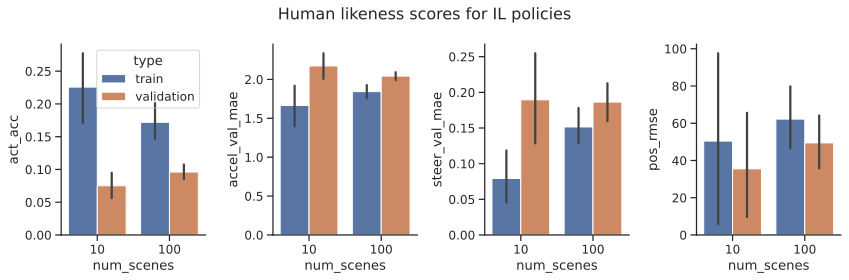

In [173]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

fig.suptitle('Human likeness scores for IL policies', fontsize=16)

sns.barplot(data=df_il, x='num_scenes', y='act_acc', hue='type', ax=axs[0], legend=True,)

sns.barplot(data=df_il, x='num_scenes', y='accel_val_mae', hue='type', ax=axs[1], legend=False)

sns.barplot(data=df_il, x='num_scenes', y='steer_val_mae', hue='type', ax=axs[2], legend=False)

sns.barplot(data=df_il, x='num_scenes', y='pos_rmse', hue='type', ax=axs[3], legend=False)

fig.tight_layout()
sns.despine()

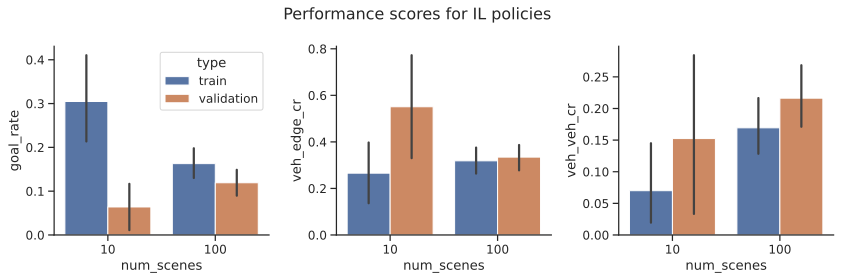

In [172]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Performance scores for IL policies', fontsize=16)

sns.barplot(data=df_il, x='num_scenes', y='goal_rate', hue='type', ax=axs[0], legend=True,)

sns.barplot(data=df_il, x='num_scenes', y='veh_edge_cr', hue='type', ax=axs[1], legend=False)

sns.barplot(data=df_il, x='num_scenes', y='veh_veh_cr', hue='type', ax=axs[2], legend=False)

fig.tight_layout()
sns.despine()